<a href="https://colab.research.google.com/github/sunnnymskang/NIST_BLE_challenge/blob/master/TC4TL_challenge_1DConvNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Inferring the distance between two devices from time stamped bluetooth signals and sensor information

This is a notebook that demonstrates one of the neural net architecture published in "Proximity Sensing for Contact Tracing"
https://arxiv.org/pdf/2009.04991.pdf

Members of Proximity sensing algorithms team at [PathCheck](https://pathcheck.org/) participated in [TC4TL challenge](https://tc4tlchallenge.nist.gov/) hosted by NIST. The challenge provided training dataset that comprised of time stamped records of bluetooth signals transmitted between two mobile devices, various sensors and meta data. While other team members developed architectures that were originally developed to consume sequential dataset (like GRU and LSTEM), I found a similarity of this problem to what Wavenet had to tackle - inferring and learning the noisy audio signal. Therefore, inspired by Wavenet's architecure, I built a 1D convolutional neural net("CNN_ForecastNet") in Pytorch that ingests fix length time series data concatenated with sensor and meta data to predict how far two devices are apart. Then I built two variations of this network that experiment with different regularization techniques - dilation("Dilated1DConvNet") and Maxpooling layers("CNN_ForecastNet_pooled"). The neural nets were evaluated based on how well it classified the distance of tthe out-of-sample dataset(namely, 1.2, 1.8, 3.0 and 4.5). In conclusion, while the best out-of-sample performance was obtained from the CNN_ForecastNet - 1D CNN with drop-out regularization, however, CNN_ForecastNet_pooled - 1D CNN with max-pool+ drop-out regularization was the only architecture that demonstrated the evidence of learning - meaning, the validation loss decreased. 
Though the TC4TL competition has closed, clear path forward is to iterate on CNN_ForecastNet_pooled with additional mechanisms for regularization (such as dilation, skip connections, batch normalization in addition to max-pooling). Other avenue of improving upon the current model is to incorporate physics-based rule on inferring distance from the set of bluetooth signals.

## Loading the dataset from Gdrive

In [ ]:
# MOUNT DRIVE + UNZIP THE DATASET ZIPS
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
!unzip /content/gdrive/My\ Drive/tc4tl2.zip
!unzip /content/gdrive/My\ Drive/tc4tl_mitre_dev.zip
!unzip /content/gdrive/My\ Drive/MITRE-Range-Angle-Structured-master.zip
!sudo tar -xvf /content/gdrive/My\ Drive/tc4tl_scoring_software_v2.tgz

Streaming output truncated to the last 5000 lines.
  inflating: tc4tl_mitre_dev/data/train/nlbwsooh_tc4tl20.csv  
  inflating: tc4tl_mitre_dev/data/train/conwqlwu_tc4tl20.csv  
  inflating: tc4tl_mitre_dev/data/train/etwnpobu_tc4tl20.csv  
  inflating: tc4tl_mitre_dev/data/train/nyoxsukg_tc4tl20.csv  
  inflating: tc4tl_mitre_dev/data/train/yebkyrrs_tc4tl20.csv  
  inflating: tc4tl_mitre_dev/data/train/jqplylmi_tc4tl20.csv  
  inflating: tc4tl_mitre_dev/data/train/qofbzkgv_tc4tl20.csv  
  inflating: tc4tl_mitre_dev/data/train/kksjdinw_tc4tl20.csv  
  inflating: tc4tl_mitre_dev/data/train/trakzoec_tc4tl20.csv  
  inflating: tc4tl_mitre_dev/data/train/umimzqwb_tc4tl20.csv  
  inflating: tc4tl_mitre_dev/data/train/qbfmuwmg_tc4tl20.csv  
  inflating: tc4tl_mitre_dev/data/train/ylzmucwt_tc4tl20.csv  
  inflating: tc4tl_mitre_dev/data/train/fsjjtahf_tc4tl20.csv  
  inflating: tc4tl_mitre_dev/data/train/wehpvizk_tc4tl20.csv  
  inflating: tc4tl_mitre_dev/data/train/cxjvyhyc_tc4tl20.csv  
  in

In [ ]:
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install torch
!pip install torchvision
!pip instaall NumPy
!pip install sklearn
!pip install matplotlib
!pip install scikit-image

  Created wheel for gputil: filename=GPUtil-1.4.0-cp36-none-any.whl size=7411 sha256=c7a18cb437302dac8fc597bd3062f149241e1bfd8c93d369fc436bb082f7031e
  Stored in directory: /root/.cache/pip/wheels/3d/77/07/80562de4bb0786e5ea186911a2c831fdd0018bda69beab71fd
Successfully built gputil
ERROR: unknown command "instaall" - maybe you meant "install"


## Utility functions for the model (**Written by co-author Sheshank Shankar**): 
1. Feature engineering timestamp records into fix length sequence, concatenated with one-hot -encoded sensor + meta information
2. Cross entropy loss for model training
3. Model evalution 


In [ ]:
# HELPER FUNCTIONS

import statistics
from sklearn.model_selection import train_test_split
import os
import random
import math
import time
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torch.nn.functional as F
from torch.autograd import Variable
import matplotlib.pyplot as plt


torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.manual_seed(0)
import numpy as np
np.random.seed(0)
random.seed(0)


NUM_READINGS_PER_INTERVAL = 150
INTERVAL_LENGTH = 4  # length in seconds of each interval


def CSELoss(predictions, targets, epsilon=1e-12):
  """
  cross entropy loss  
  """

  predictions = torch.clamp(predictions, epsilon, 1. - epsilon)
  N = predictions.shape[0]
  ce = -torch.sum(targets*torch.log(predictions+1e-9))/N
  return ce

def load_data(key_path, data_path):
    """
    This loads the NIST data set under tc4tl dev/test
    """
    # Process event transmitter/receiver info
    # transmitter/receiver device, transmitter power
    # transmitter/receiver carrying spot, transmitter/receiver carrying pose
    # these need to be fed into the neural net as extra information 
    fixed_variables_possible_values = [set() for _ in range(9)]
    class_labels_possible_values = set()

    for file_id in os.listdir(data_path):
        if file_id.startswith("."):
            # there are some weird extra files starting with .
            continue
        with open(os.path.join(data_path, file_id), 'r', errors="ignore") as data_file:
            for index in range(7):
                value = data_file.readline().strip().split(",")[1]
                fixed_variables_possible_values[index].add(value)
    with open(key_path, 'r', errors="ignore") as key_file:
        key_file.readline()  # skip header
        for line in key_file:
            record = line.split("\t")
            transmitter_position, receiver_position = record[1].split("_")
            if len(record) == 5:
                # has labels
                class_labels_possible_values.add(float(record[2]))
              # duplicate information?
            fixed_variables_possible_values[7].add(transmitter_position)
            fixed_variables_possible_values[8].add(receiver_position)
    fixed_variables_possible_values = [list(fixed_variable_possible_values) for fixed_variable_possible_values in fixed_variables_possible_values]
    class_labels_possible_values = list(class_labels_possible_values)
    # fixed_variables_possible_values: list of unique meta data information in training/dev
    # class_labels_possible_values: list of unique label information in training/dev/test

    X = list()  # each intervals index in this list gives you the input features
    y = list()  # each intervals index in this list gives you the label
    interval_to_file = list()  # this is used to output predictions. Each intervals index in this list gives you the file that the interval was from
    with open(key_path, 'r') as key_file:
        key_file.readline()  # skip header
        for line in key_file:
            record = line.split("\t")
            file_id = record[0]
            with open(os.path.join(data_path, file_id)) as data_file:
                # fixed variables tx_device, tx_power, rx_device, tx_carry, rx_carry, rx_pose, tx_pose,
                #                               transmitter_position, receiver_position
                fixed_variables = [data_file.readline().strip().split(",")[1] for _ in range(7)]
                fixed_variables.extend(record[1].split("_"))
                fixed_part = list()
                for variable, key in zip(fixed_variables, fixed_variables_possible_values):
                  # One hot encoding the meta data information 
                    fixed_part.extend([int(possible_value == variable) for possible_value in key])
                print("Loading file {} with fixed variables of {}".format(file_id, fixed_part))
                
                # now let's process the timestamped information
                # Timestampped events occur in multiples of 4 seconds long recording period 
                # the interval in between successive 4sec long windows are unique to each event file
                interval_start_time = 0
                interval_data = list()
                num_intervals = 0
                reading_count = 0
                # this is used because each line only has one sensors reading. The other valaues need to be populated by the previous sensor readings
                previous_value = {
                    "Bluetooth": (0,),
                    "Accelerometer": (0,0,0),
                    "Gyroscope": (0,0,0),
                    "Altitude": (0,0),
                    "Attitude": (0,0,0),
                    # "Activity": (0,0),
                    "Gravity": (0,0,0),
                    "Magnetic-field": (0,0,0),
                    "Heading": (0,0,0,0)
                }
                for line in data_file:

                    reading = line.strip().split(",")
                    curr_time = float(reading[0])

                    # data augmentation: 
                    # 1) random data removal: if the window remained > 4 sec && > threshold # of readingss
                    # 2) random data duplication: if the window if the window remained > 4 sec

                    if (curr_time - interval_start_time) > INTERVAL_LENGTH:
                        if reading_count > NUM_READINGS_PER_INTERVAL:
                            # randomly remove readings
                            for _ in range(reading_count - NUM_READINGS_PER_INTERVAL):
                                interval_data.pop(math.floor(random.random() * len(interval_data)))
                        else:
                            # randomly duplicate readings
                            # todo: try other methods such as averaging
                            for _ in range(NUM_READINGS_PER_INTERVAL - reading_count):
                                random_index = math.floor(random.random() * len(interval_data))
                                interval_data.insert(random_index, interval_data[random_index])
                        X.append(interval_data)
                        num_intervals += 1

                        # Begin new event (which will last for INTERVAL_LENGTH )
                        interval_start_time = curr_time
                        reading_count = 0
                        interval_data = list()
                        previous_value = {
                            "Bluetooth": (0,),
                            "Accelerometer": (0,0,0),
                            "Gyroscope": (0,0,0),
                            "Altitude": (0,0),
                            "Attitude": (0,0,0),
                            # "Activity": (0,0),
                            "Gravity": (0,0,0),
                            "Magnetic-field": (0,0,0),
                            "Heading": (0,0,0,0)
                        }
                    
                    # Update the sensor information accordingly
                    type = reading[1]
                    if type in {"Pedometer", "Activity"}: #, "Heading", "Altitude", "Attitude", "Gravity"}:
                        continue
                    elif type == "Bluetooth":
                        previous_value[type] = (float(reading[2]), )
                    elif type == "Heading":
                        previous_value[type] = (float(reading[2]), float(reading[3]), float(reading[4]),
                                                float(reading[5]))
                    elif type == "Altitude":
                        previous_value[type] = (float(reading[2]), float(reading[3]))
                    elif type == "Activity":
                        # todo: add one-hot encoding for reading[3]
                        # todo: remove this, it is useless with oh
                        previous_value[type] = (float(reading[2]), float(reading[4]))
                    else:
                        previous_value[type] = (float(reading[2]), float(reading[3]), float(reading[4]))
                    # combine the values in previous_value into one giant list
                    # Uses 0 as angle for nist data
                    interval_data.append([0] + [reading for value in previous_value.values() for reading in value] )# + fixed_part)
                    reading_count += 1
                
                # the last interval needs to be added manually
                # I don't understand why this part repeats itself 
                if reading_count > NUM_READINGS_PER_INTERVAL:
                    # randomly remove readings
                    for i in range(reading_count - NUM_READINGS_PER_INTERVAL):
                        interval_data.pop(math.floor(random.random() * len(interval_data)))
                else:
                    # randomly duplicate readings
                    # todo: try other methods such as averaging
                    for i in range(NUM_READINGS_PER_INTERVAL - reading_count):
                        random_index = math.floor(random.random() * len(interval_data))
                        interval_data.insert(random_index, interval_data[random_index])
                X.append(interval_data)
                num_intervals += 1

            if len(record) == 5:
                # this means this file has labels
                distance = float(record[2])
                # I think it should be len(class_labels_possible_values)
                label = torch.zeros(INTERVAL_LENGTH)
                # label is created for each interval of the event file
                # 1 for the class it belongs, zero for others 
                label[class_labels_possible_values.index(distance)] = 1
                for _ in range(num_intervals):
                    y.append(label)
                    
            print(num_intervals)
            for _ in range(num_intervals):
                interval_to_file.append(file_id)

            # good for debugging
            # if len(X) > 105:
            #     break
    return [torch.Tensor(interval) for interval in X], y, class_labels_possible_values, interval_to_file

# tc4tl challenge organizer has asked us not to use these files
BAD_DATASETS = {"set_7", "set_8", "set_15", "set_24", "set_25", "set_29", 
                "set_35", "set_38", "set_47", "set_48", "set_58", "set_61", 
                "set_62", "set_63", "set_66", "set_67", "set_68", "set_69", 
                "set_70" "set_1", "set_18", "set_30", "set_32", "set_33",
                "set_36", "set_41", "set_45", "set_51", "set_59", "set_61",
                "set_62", "set_63", "set_66", "set_68", "set_69", "set_70", 
                "set_72", "set_73"}
print(len(BAD_DATASETS))

def chunks(lst, n):
    """Yield successive n-sized chunks from lst."""
    interval = len(lst) // n
    for i in range(0, len(lst), interval):
        yield lst[i:i + interval]


def load_mitre_data(data_path):
    """
    loading the mitre dataset
    This dataset contains measurements following the Range-Angle Collection Protocol collected by MITRE employees. 
    For measurments using two iPhones, the BluetoothProximity app was used to broadcast the BLE advertisement from 
    one device following the standard test protocol. For measurements using an iPhone and an Android device, 
    the nRF Connect app was used on the Andriod device to broadcast the BLE advertisement.
    """

    # one hot encoded label vector
    class_labels_possible_values = [1.2, 1.8, 3.0, 4.5]

    X = list()  # each intervals index in this list gives you the input features
    y = list()  # each intervals index in this list gives you the label

    experiment_paths = [os.path.join(data_path, name) for name in os.listdir(data_path)
                   if os.path.isdir(os.path.join(data_path, name)) and not name.startswith(".") and name not in BAD_DATASETS]
    for experiment_path in experiment_paths:
        print(experiment_path)
        log_file_paths = [os.path.join(experiment_path, log_filename) for log_filename in os.listdir(experiment_path)
                    if os.path.isfile(os.path.join(experiment_path, log_filename))]
        for log_file_path in log_file_paths:
            if log_file_path.endswith(".swp"):
                continue
            with open(log_file_path, 'r', errors='ignore') as log_file:
                # same logic as load_data
                previous_value = {
                    "Bluetooth": (0,),
                    "Accelerometer": (0, 0, 0),
                    "Gyroscope": (0, 0, 0),
                    "Altitude": (0, 0),
                    "Attitude": (0, 0, 0),
                    # "Activity": (0, 0),
                    "Gravity": (0, 0, 0),
                    "Magnetic-field": (0, 0, 0),
                    "Heading": (0, 0, 0, 0)
                }
                # this list contains of all the readings for each ten second interval
                ten_sec_data = list()
                label = 0
                for line in log_file:
                    record = line.strip().split(",")
                    if "app_name" in line:
                        # new interval
                        # timestamp = datetime.datetime.strptime(record[0], "%Y-%m-%dT%H:%M:%S.%fZ")
                        if len(ten_sec_data) > 10 and feet_distance != 4.5:
                            # nist dataset uses 4 second intervals, so splitting this into 10 1 second intervals allows us to get 7 4 second intervals from the 10 second interval.
                            seconds_data = list(chunks(ten_sec_data, 10))
                            for i in range(0, len(seconds_data) - INTERVAL_LENGTH):
                                interval_data = [item for sublist in seconds_data[i:i + INTERVAL_LENGTH] for item in sublist]
                                if len(interval_data) > NUM_READINGS_PER_INTERVAL:
                                    # remove readings based on skip
                                    selected_indexes = np.round(np.linspace(0, len(interval_data) - 1, NUM_READINGS_PER_INTERVAL)).astype(int)
                                    interval_data = [interval_data[idx] for idx in selected_indexes]
                                else:
                                    # randomly duplicate readings
                                    # todo: try other methods such as averaging
                                    for i in range(NUM_READINGS_PER_INTERVAL - len(interval_data)):
                                        random_index = math.floor(random.random() * len(interval_data))
                                        interval_data.insert(random_index, interval_data[random_index])
                                X.append(interval_data)
                                y.append(label)
                        ten_sec_data = list()
                        reading_count = 0
                        previous_value = {
                            "Bluetooth": (0,),
                            "Accelerometer": (0, 0, 0),
                            "Gyroscope": (0, 0, 0),
                            "Altitude": (0, 0),
                            "Attitude": (0, 0, 0),
                            # "Activity": (0, 0),
                            "Gravity": (0, 0, 0),
                            "Magnetic-field": (0, 0, 0),
                            "Heading": (0, 0, 0, 0)
                        }
                        distance = next(log_file)
                        while "Range" not in distance:
                            # skip fixed for now
                            distance = next(log_file)
                        distance = int(distance.split(",")[-1])

                        # convert feet to meters
                        if distance <= 5.5:
                          feet_distance = 1.2
                        elif distance <= 8:
                          feet_distance = 1.8
                        elif distance <= 12:
                          feet_distance = 3.0
                        else:
                          feet_distance = 4.5
                        label = torch.zeros(len(class_labels_possible_values))
                        label[class_labels_possible_values.index(feet_distance)] = 1
                        
                        angle_record = next(log_file)
                        angle = int(angle_record.split(",")[2])

                        record = next(log_file).split(",")
                    # timestamp - log_file_interval_data[-1]["start"]
                    type = record[1]

                    # these are the sensor readings we want to ignore for now
                    if type in {"Pedometer", "Activity"}: #, "Heading", "Altitude", "Attitude", "Gravity"}:
                        continue
                    elif type == "Bluetooth":
                        previous_value[type] = (float(record[3]),)
                    elif type == "Heading":
                        previous_value[type] = (float(record[2]), float(record[3]), float(record[4]),
                                                float(record[5]))
                    elif type == "Altitude":
                        previous_value[type] = (float(record[2]), float(record[3]))
                    elif type == "Activity":
                        # todo: add one-hot encoding for reading[3]
                        previous_value[type] = (0, float(record[4]))
                    else:
                        previous_value[type] = (float(record[2]), float(record[3]), float(record[4]))
                    # combine the values in previous_value into one giant list
                    ten_sec_data.append(
                        [angle] + [reading for value in previous_value.values() for reading in value])  # + fixed_part)
                    reading_count += 1
                # last needs to be added manually
                if len(ten_sec_data) > 10 and feet_distance != 4.5:
                    seconds_data = list(chunks(ten_sec_data, 10))
                    for i in range(0, len(seconds_data) - INTERVAL_LENGTH):
                        interval_data = [item for sublist in seconds_data[i:i + INTERVAL_LENGTH] for item in sublist]
                        if len(interval_data) > NUM_READINGS_PER_INTERVAL:
                            # remove readings based on skip
                            selected_indexes = np.round(np.linspace(0, len(interval_data) - 1, NUM_READINGS_PER_INTERVAL)).astype(int)
                            interval_data = [interval_data[idx] for idx in selected_indexes]
                        else:
                            # randomly duplicate readings
                            # todo: try other methods such as averaging
                            for i in range(NUM_READINGS_PER_INTERVAL - len(interval_data)):
                                random_index = math.floor(random.random() * len(interval_data))
                                interval_data.insert(random_index, interval_data[random_index])
                        X.append(interval_data)
                        y.append(label)
    return [torch.Tensor(interval) for interval in X], y


def eval_model(model, val_data_loader, best_acc, save=True):
  model.eval()
  predict_dist = {0:0,1:0,2:0,3:0}
  label_dist = {0:0,1:0,2:0,3:0}
  with torch.no_grad():
      test_total_loss = list()
      test_total_acc = list()
      test_total_tc_acc = list()
      for idx, batch in enumerate(val_data_loader):
          input = batch[0]
          label = torch.max(batch[1],axis=1)[1]
          for lab in label:
            label_dist[int(lab)] += 1
          # if idx % 100 == 0:
          #   print("label {}".format(label))
          prediction = model(input) #, batch_size=len(label))
          loss = loss_fn(prediction, batch[1])
          prediction = torch.max(prediction, 1)[1].view(label.size())
          for pred in prediction:
            predict_dist[int(pred)] += 1
          # if idx % 100 == 0:
          #   print("pred {}".format(prediction))
          num_corrects = (prediction == label).float().sum()
          acc = 100.0 * num_corrects / len(label)
          prediction = ((prediction == 0) + (prediction == 3).float())
          label = ((label == 0) + (label == 3).float())
          num_tc_corrects = (label == prediction).float().sum()
          tc_acc = 100.0 * num_tc_corrects / len(label)
          test_total_loss.extend([loss.item()] * len(label))
          test_total_acc.extend([acc.item()] * len(label))
          test_total_tc_acc.extend([tc_acc.item()] * len(label))
          # if idx % 100 == 0:
          #   print("acc {}".format(acc))
      curr_acc = statistics.mean(test_total_acc)
      if best_acc < curr_acc and save:
        torch.save(model.state_dict(), MODEL_PATH)
        best_acc = curr_acc
      print(predict_dist)
      print(label_dist)
      return statistics.mean(test_total_loss), statistics.mean(test_total_acc), statistics.mean(test_total_tc_acc), best_acc
import json

def output_predictions(model, X, labels_to_distance, intervals_to_file, output_path):
  model.eval()
  print(list(intervals_to_file))
  with torch.no_grad():
      with open(output_path, "w") as f:
        f.write("fileid\tdistance\n")
        file_to_interval_pred = dict()
        i = 0
        for tensor, file_id in zip(X, intervals_to_file):
            i+=1
            print(i)
            if file_id not in file_to_interval_pred:
              file_to_interval_pred[file_id] = list()            
            input = tensor.view(1, tensor.shape[0], tensor.shape[1])
            prediction = model(input)#, batch_size=1)
            prediction = labels_to_distance[torch.max(prediction, 1)[1]]
            file_to_interval_pred[file_id].append(str(prediction))
        file_to_pred = [file_id + "\t" + max(set(preds), key=preds.count) for file_id, preds in file_to_interval_pred.items()]
        print(len(file_to_pred))
        file_to_pred.sort()
        f.write("\n".join(file_to_pred))
  return

31


# Building 1D Conv Net (**My contribution**):
1. CNN_ForecasetNet: 1D CNN --> dropout --> 2 FCs
2. Dilated1DConvNet: 4 * 1D CNN with dilations --> dropout --> 2 FCs  
3. CNN_ForecastNet_pooled: 3* 1D CNN with max pool --> dropout --> 2 FCs


In [ ]:
class CNN_ForecastNet(nn.Module):
    def __init__(self,input_size, len_timestamp, hidden_size, output_size, kernel_size):
        super(CNN_ForecastNet,self).__init__()

        self.input_size= input_size
        self.len_timestamp= len_timestamp
        self.hidden_size= hidden_size
        self.kernel_size= kernel_size
        self.output_size= output_size
        self.padding = kernel_size // 2
        
        self.conv1d = nn.Conv1d(self.input_size,self.hidden_size,kernel_size=3,padding=self.padding)
        self.conv_outdim = (self.len_timestamp + 2*self.padding-1*(3-1)-1)+1
        self.linear_input_size = self.hidden_size * self.conv_outdim 
        self.relu = nn.ReLU(inplace=True)
        self.fc1 = nn.Linear(self.linear_input_size,128)
        self.fc2 = nn.Linear(128,self.output_size)
        self.softmax = nn.Softmax()
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout()


    def forward(self,x):
        x = x.permute(0,2,1)
        x = self.conv1d(x)
        x = self.relu(x)
        x= self.dropout(x)
        x= x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        y_pred = self.softmax(x)
        return y_pred

In [ ]:
class Dilated1DConvNet(nn.Module):
    def __init__(self,input_size, len_timestamp, hidden_size, output_size, kernel_size, dilation=2 ):
        super(Dilated1DConvNet,self).__init__()

        self.input_size= input_size
        self.len_timestamp= len_timestamp
        self.hidden_size= hidden_size
        self.kernel_size= kernel_size
        self.output_size= output_size
        self.dilation = dilation
        self.padding = dilation*(kernel_size-1) // 2
        # Wavenet inspired 1D Convnet: https://louisenaud.github.io/time_series_prediction.html
        #Layer 1
        self.dilated_conv1 = nn.Conv1d(self.input_size, self.hidden_size, kernel_size=3, padding=self.padding, dilation=self.dilation)
        # Calculate the linear layer input size here: which is 
        self.relu1 = nn.ReLU()

        # Layer 2
        self.dilated_conv2 = nn.Conv1d(self.hidden_size, self.hidden_size, kernel_size=1, dilation=self.dilation)
        self.relu2 = nn.ReLU()

        # Layer 3
        self.dilated_conv3 = nn.Conv1d(self.hidden_size, self.hidden_size, kernel_size=1, dilation=self.dilation)
        self.relu3 = nn.ReLU()

        # Layer 4
        self.dilated_conv4 = nn.Conv1d(self.hidden_size, self.hidden_size, kernel_size=1, dilation=self.dilation)
        self.relu4 = nn.ReLU()

        # Output layer
        self.conv_outdim = self.len_timestamp # padding and kernel was chosen to preserve the total timestamp length
        self.linear_input_size = self.hidden_size * self.conv_outdim 
        self.fc1 = nn.Linear(self.linear_input_size,128)
        self.fc2 = nn.Linear(128,self.output_size)
        self.softmax = nn.Softmax()
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout()


    def forward(self,x):
        x = x.permute(0,2,1)

        # First layer
        out = self.dilated_conv1(x)
        out = self.relu1(out)
        
        # Layer 2:
        out = self.dilated_conv2(out)
        out = self.relu2(out)

        # Layer 3:
        out = self.dilated_conv3(out)
        out = self.relu3(out)

        # Layer 4:
        out = self.dilated_conv4(out)
        out = self.relu4(out)

        out= self.dropout(out)
        out= out.view(out.size(0), -1)

        out = self.fc1(out)
        out = self.relu(out)
        out = self.fc2(out)
        y_pred = self.softmax(out)
        return y_pred




In [ ]:
class CNN_ForecastNet_pooled(nn.Module):
    def __init__(self,input_size, len_timestamp, hidden_size, output_size, kernel_size):
        super(CNN_ForecastNet_pooled,self).__init__()

        self.input_size= input_size
        self.len_timestamp= len_timestamp
        self.hidden_size= hidden_size
        self.kernel_size= kernel_size
        self.output_size= output_size
        self.padding = kernel_size // 2
        
        self.conv1 = nn.Conv1d(self.input_size, self.hidden_size, kernel_size=3, padding=self.padding)
        self.conv2 = nn.Conv1d(self.hidden_size, self.hidden_size // 2, kernel_size=3, padding=self.padding)
        self.conv3 = nn.Conv1d(self.hidden_size // 2, self.hidden_size // 2, kernel_size=3, padding=self.padding)
        #self.maxpool1d = nn.MaxPool1d(kernel_size=3)
        self.conv_outdim = (self.len_timestamp //16)
        self.linear_input_size = self.hidden_size * self.conv_outdim
        self.fc1 = nn.Linear(self.linear_input_size, 128)
        self.fc2 = nn.Linear(128, self.output_size)
        self.softmax = nn.Softmax()
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout()

    def forward(self,x):

        x = x.permute(0,2,1)
        out = nn.functional.max_pool1d(self.relu(self.conv1(x)), 2)
        out1 = out
        out= self.dropout(out)
        out = nn.functional.max_pool1d(self.relu(self.conv2(out)), 2)
        out= self.dropout(out)
        out = nn.functional.max_pool1d(self.relu(self.conv3(out)), 2)
        out= self.dropout(out)
        out= out.view(out.size(0), -1)
        out = self.relu(self.fc1(out))
        out = self.fc2(out)
        y_pred = self.softmax(out)

        return y_pred


In the following section I demonstrate the data split, training and evaluation on one of the architecture I developed (CNN_ForecastNet_pooled). I used the identical code to train and evaluate other two architectures I built

## Dataset split: train, test, dev

In [ ]:
EXP_NAME = "CNN_ForecastNet_pooled"
train_key_path = os.path.join("/content", "tc4tl_mitre_dev", "docs", "tc4tl_train_key.tsv")
train_data_path = os.path.join("/content", "tc4tl_mitre_dev", "data", "train")
train_X, train_y, train_labels_to_distance, train_intervals_to_file = load_data(train_key_path, train_data_path)
np.save("/content/gdrive/My Drive/train_X_numpy.npy".format(EXP_NAME), [tensor.numpy() for tensor in train_X])
np.save("/content/gdrive/My Drive/train_y_numpy.npy".format(EXP_NAME), [tensor.numpy() for tensor in train_y])
np.save("/content/gdrive/My Drive/train_file_names_numpy.npy", np.array(train_intervals_to_file))
print(set(train_y))
test_key_path = os.path.join("/content", "tc4tl", "docs", "tc4tl_test_metadata.tsv")
test_data_path = os.path.join("/content", "tc4tl", "data", "test")
test_X, _, test_labels_to_distance, test_intervals_to_file = load_data(test_key_path, test_data_path)
val_key_path = os.path.join("/content", "tc4tl", "docs", "tc4tl_dev_key.tsv")
val_data_path = os.path.join("/content", "tc4tl", "data", "dev")
val_X, val_y, labels_to_distance, dev_interval_to_file = load_data(val_key_path, val_data_path)

Streaming output truncated to the last 5000 lines.
4
Loading file vcpfqrze_tc4tl20.csv with fixed variables of [0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0]
5
Loading file vcrpkrnm_tc4tl20.csv with fixed variables of [0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0]
4
Loading file vcupbapd_tc4tl20.csv with fixed variables of [0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1]
4
Loading file vcwydyyh_tc4tl20.csv with fixed variables of [0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0]
4
Loading file vdahsnea_tc4tl20.csv with fixed variables of [0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1]
16
Loading file vdpyxpgh_tc4tl20.csv with fixed variables of [0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0]
32
Loading file vdrsvygl

In [ ]:
# RUN TO LOAD SAVED NPY DATA

import numpy as np

def generate_synthetic_hybrids(X, y, num_new_samples=1000):
  orig_X = X.copy()
  orig_y = y.copy()
  dataset_size = len(orig_y)
  for i in range(num_new_samples):
    a_index = random.randint(0, dataset_size - 1)
    a_y = orig_y[a_index]
    a_X = orig_X[a_index]
    b_index = random.randint(0, dataset_size - 1)
    b_y = orig_y[b_index]
    while (int(sum((b_y + a_y)[1:3])) % 2 != 0) or torch.equal(b_y, a_y):
      b_index = random.randint(0, dataset_size - 1)
      b_y = orig_y[b_index]
    b_X = orig_X[b_index]
    lam = np.random.beta(0.2, 0.2)
    new_X = lam * a_X + (1 - lam) * b_X
    new_y = lam * a_y + (1 - lam) * b_y
    X.append(new_X)
    y.append(new_y)
  return X, y

with open("/content/gdrive/My Drive/train_X_numpy.npy", 'rb') as f:
  train_X = [torch.from_numpy(el) for el in np.load(f)]
with open("/content/gdrive/My Drive/train_y_numpy.npy", 'rb') as f:
  train_y = [torch.from_numpy(el) for el in np.load(f)]

train_data_loader = DataLoader(list(zip(train_X, train_y)), batch_size=128, drop_last=True)
val_data_loader = DataLoader(list(zip(val_X, val_y)), batch_size=128,drop_last=True)
test_data_loader= DataLoader(list(zip(test_X, _)), batch_size=128,drop_last=True)

## Training the archiecture


CNN_ForecastNet_pooled(
  (conv1): Conv1d(23, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (conv2): Conv1d(64, 32, kernel_size=(3,), stride=(1,), padding=(1,))
  (conv3): Conv1d(32, 32, kernel_size=(3,), stride=(1,), padding=(1,))
  (fc1): Linear(in_features=576, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=4, bias=True)
  (softmax): Softmax(dim=None)
  (relu): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


before eval
{0: 4825, 1: 15, 2: 1796, 3: 20}
{0: 756, 1: 865, 2: 2634, 3: 2401}
Testing Loss: 1.4265189239611993, AVG: 19.71153846153846, TC4TL or Not AVG: 50.12019230769231
Epoch: 1, Training Loss: 1.6172, Training Accuracy:  33.53% TC4TL or Not ACC:  49.66%
before eval
{0: 1616, 1: 69, 2: 4947, 3: 24}
{0: 756, 1: 865, 2: 2634, 3: 2401}
Testing Loss: 1.4038946124223561, AVG: 32.49699519230769, TC4TL or Not AVG: 51.06670673076923
Epoch: 2, Training Loss: 1.3518, Training Accuracy:  36.17% TC4TL or Not ACC:  49.67%
before eval
{0: 1154, 1: 38, 2: 5456, 3: 8}
{0: 756, 1: 865, 2: 2634, 3: 2401}
Testing Loss: 1.3946544573857234, AVG: 34.42007211538461, TC4TL or Not AVG: 50.76622596153846
Epoch: 3, Training Loss: 1.2989, Training Accuracy:  37.10% TC4TL or Not ACC:  49.90%
before eval
{0: 720, 1: 6, 2: 5903, 3: 27}
{0: 756, 1: 865, 2: 2634, 3: 2401}
Testing Loss: 1.389985134968391, AVG: 36.43329326923077, TC4TL or Not AVG: 52.07331730769231
Epoch: 4, Training Loss: 1.2809, Training Accuracy

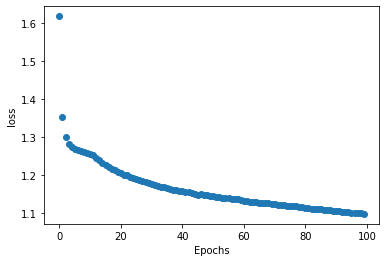

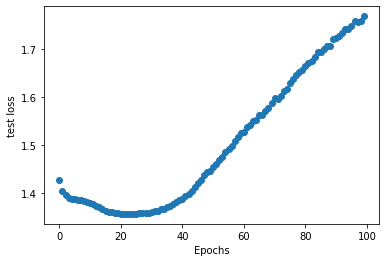

{0: 3315, 1: 0, 2: 3187, 3: 154}
{0: 756, 1: 865, 2: 2634, 3: 2401}
Testing Loss: 1.7689311733612647, AVG: 32.99278846153846, TC4TL or Not AVG: 60.45673076923077
39.99399038461539


In [ ]:
import torch.optim as optim
from torch.optim import lr_scheduler

EXP_NAME = "CNN_ForecastNet_pooled"
MODEL_PATH = "/content/gdrive/My Drive/MITRE_layers_2_epochs_20_{}.pth".format(EXP_NAME)
labels_to_distance = [1.2, 3.0, 4.5,1.8]
num_features = 23 

model =CNN_ForecastNet_pooled(input_size=num_features,len_timestamp =NUM_READINGS_PER_INTERVAL, hidden_size=64, output_size=len(labels_to_distance), kernel_size=3)
print(model)
best_acc = 0
total_loss = []  # for plotting
total_test_loss = []
loss_fn = CSELoss
train_start_time = time.time()
epoch_num=100

for epoch in range(epoch_num):
    total_epoch_loss = 0
    total_epoch_acc = 0
    total_epoch_tc_acc = 0
    # optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
    # exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
    optim = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-5,weight_decay=1e-4)
    steps = 0
    model.train()
    for idx, batch in enumerate(train_data_loader):
        input = batch[0]
        label = torch.max(batch[1], axis=1)[1]
        optim.zero_grad()
        prediction = model(input)#, batch_size=len(label))
        loss = loss_fn(prediction, batch[1])
        prediction = torch.max(prediction, 1)[1].view(label.size())

        num_corrects = (prediction == label).float().sum()
        acc = 100.0 * num_corrects / len(label)
        prediction = ((prediction == 0) + (prediction == 3).float())
        label = ((label == 0) + (label == 3).float())
        num_tc_corrects = (label == prediction).float().sum()
        tc_acc = 100.0 * num_tc_corrects / len(label)
        loss.backward()
        optim.step()
        steps += 1
        total_epoch_loss += loss.item()
        total_epoch_acc += acc.item()
        total_epoch_tc_acc += tc_acc.item()
    # eval
    print("before eval")
    loss, acc, tc_acc, best_acc = eval_model(model, val_data_loader, best_acc)
    print("Testing Loss: {}, AVG: {}, TC4TL or Not AVG: {}".format(loss, acc, tc_acc))
    total_loss.append((epoch, total_epoch_loss/steps))
    total_test_loss.append((epoch, loss))
    print (f'Epoch: {epoch+1}, Training Loss: {total_epoch_loss/steps:.4f}, Training Accuracy: {total_epoch_acc/steps: .2f}% TC4TL or Not ACC: {total_epoch_tc_acc/steps: .2f}%')
print("finished training, took {} seconds".format(time.time() - train_start_time))
plt.scatter(*zip(*total_loss))
plt.xlabel("Epochs")
plt.ylabel("loss")
plt.show()
plt.scatter(*zip(*total_test_loss))
plt.xlabel("Epochs")
plt.ylabel("test loss")
plt.show()

# eval
loss, acc, tc_acc, best_acc = eval_model(model, val_data_loader, best_acc)
print("Testing Loss: {}, AVG: {}, TC4TL or Not AVG: {}".format(loss, acc, tc_acc))
print(best_acc)

## Evaluating on validation set 

In [ ]:

# TEST ON VAL SECTION OF DEV DATA
EXP_NAME = "CNN_ForecastNet_pooled"
MODEL_PATH = "/content/gdrive/My Drive/MITRE_layers_2_epochs_20_{}.pth".format(EXP_NAME)
labels_to_distance = [1.2, 3.0, 4.5,1.8]
num_features = 23 
best_acc=0

val_data_loader = DataLoader(list(zip(val_X, val_y)), batch_size=128, drop_last=True)
model_test = CNN_ForecastNet_pooled(input_size=num_features,len_timestamp =NUM_READINGS_PER_INTERVAL, hidden_size=64, output_size=len(labels_to_distance), kernel_size=3)
model_test.load_state_dict(torch.load(MODEL_PATH))
print(model_test)
print(sum(p.numel() for p in model_test.parameters()))
output_predictions(model_test, val_X, labels_to_distance, dev_interval_to_file, "/content/gdrive/My Drive/MITRE_{}_layers_2_.tsv".format(EXP_NAME))

CNN_ForecastNet_pooled(
  (conv1): Conv1d(23, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (conv2): Conv1d(64, 32, kernel_size=(3,), stride=(1,), padding=(1,))
  (conv3): Conv1d(32, 32, kernel_size=(3,), stride=(1,), padding=(1,))
  (fc1): Linear(in_features=576, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=4, bias=True)
  (softmax): Softmax(dim=None)
  (relu): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
)
88132
['abgikaek_tc4tl20.csv', 'abgikaek_tc4tl20.csv', 'abgikaek_tc4tl20.csv', 'abgikaek_tc4tl20.csv', 'acehqsss_tc4tl20.csv', 'acehqsss_tc4tl20.csv', 'acehqsss_tc4tl20.csv', 'acehqsss_tc4tl20.csv', 'acehqsss_tc4tl20.csv', 'acehqsss_tc4tl20.csv', 'adcmsfnp_tc4tl20.csv', 'adcmsfnp_tc4tl20.csv', 'adcmsfnp_tc4tl20.csv', 'adcmsfnp_tc4tl20.csv', 'adljjzjj_tc4tl20.csv', 'adljjzjj_tc4tl20.csv', 'adzvqmmg_tc4tl20.csv', 'adzvqmmg_tc4tl20.csv', 'adzvqmmg_tc4tl20.csv', 'adzvqmmg_tc4tl20.csv', 'adzvqmmg_tc4tl20.csv', 'adzvqmmg_tc4tl20.csv', 'adzvqmmg_tc4

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
1717
1718
1719
1720
1721
1722
1723
1724
1725
1726
1727
1728
1729
1730
1731
1732
1733
1734
1735
1736
1737
1738
1739
1740
1741
1742
1743
1744
1745
1746
1747
1748
1749
1750
1751
1752
1753
1754
1755
1756
1757
1758
1759
1760
1761
1762
1763
1764
1765
1766
1767
1768
1769
1770
1771
1772
1773
1774
1775
1776
1777
1778
1779
1780
1781
1782
1783
1784
1785
1786
1787
1788
1789
1790
1791
1792
1793
1794
1795
1796
1797
1798
1799
1800
1801
1802
1803
1804
1805
1806
1807
1808
1809
1810
1811
1812
1813
1814
1815
1816
1817
1818
1819
1820
1821
1822
1823
1824
1825
1826
1827
1828
1829
1830
1831
1832
1833
1834
1835
1836
1837
1838
1839
1840
1841
1842
1843
1844
1845
1846
1847
1848
1849
1850
1851
1852
1853
1854
1855
1856
1857
1858
1859
1860
1861
1862
1863
1864
1865
1866
1867
1868
1869
1870
1871
1872
1873
1874
1875
1876
1877
1878
1879
1880
1881
1882
1883
1884
1885
1886
1887
1888
1889
1890
1891
1892
1893
1894
1895
1896
1897
1898
1899
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909

## Evaluating on the test set for the competition entry 

In [ ]:

EXP_NAME = "CNN_ForecastNet_pooled"
MODEL_PATH = "/content/gdrive/My Drive/MITRE_layers_2_epochs_20_{}.pth".format(EXP_NAME)
labels_to_distance = [1.2, 3.0, 4.5,1.8]
num_features = 23 
best_acc=0

#val_data_loader = DataLoader(list(zip(val_X, val_y)), batch_size=50, drop_last=True)
model_test = CNN_ForecastNet_pooled(input_size=num_features,len_timestamp =NUM_READINGS_PER_INTERVAL, hidden_size=64, output_size=len(labels_to_distance), kernel_size=3)
model_test.load_state_dict(torch.load(MODEL_PATH))
print(len(test_X))
print(model_test)
print(sum(p.numel() for p in model_test.parameters()))
output_predictions(model_test, test_X, labels_to_distance, test_intervals_to_file , "/content/gdrive/My Drive/MITRE_{}_layers_2_final_output.tsv".format(EXP_NAME))


57428
CNN_ForecastNet_pooled(
  (conv1): Conv1d(23, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (conv2): Conv1d(64, 32, kernel_size=(3,), stride=(1,), padding=(1,))
  (conv3): Conv1d(32, 32, kernel_size=(3,), stride=(1,), padding=(1,))
  (fc1): Linear(in_features=576, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=4, bias=True)
  (softmax): Softmax(dim=None)
  (relu): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
)
88132
['aaafrwlt_tc4tl20.csv', 'aaafrwlt_tc4tl20.csv', 'aaafrwlt_tc4tl20.csv', 'aaafrwlt_tc4tl20.csv', 'aaafrwlt_tc4tl20.csv', 'aaafrwlt_tc4tl20.csv', 'aaafrwlt_tc4tl20.csv', 'aaafrwlt_tc4tl20.csv', 'aaafrwlt_tc4tl20.csv', 'aaafrwlt_tc4tl20.csv', 'aaafrwlt_tc4tl20.csv', 'aaafrwlt_tc4tl20.csv', 'aaafrwlt_tc4tl20.csv', 'aaafrwlt_tc4tl20.csv', 'aaafrwlt_tc4tl20.csv', 'aaafrwlt_tc4tl20.csv', 'aaafrwlt_tc4tl20.csv', 'aaafrwlt_tc4tl20.csv', 'aaasqzop_tc4tl20.csv', 'aaasqzop_tc4tl20.csv', 'aaasqzop_tc4tl20.csv', 'aaasqzop_tc4tl20.csv', 'aabadz

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
52431
52432
52433
52434
52435
52436
52437
52438
52439
52440
52441
52442
52443
52444
52445
52446
52447
52448
52449
52450
52451
52452
52453
52454
52455
52456
52457
52458
52459
52460
52461
52462
52463
52464
52465
52466
52467
52468
52469
52470
52471
52472
52473
52474
52475
52476
52477
52478
52479
52480
52481
52482
52483
52484
52485
52486
52487
52488
52489
52490
52491
52492
52493
52494
52495
52496
52497
52498
52499
52500
52501
52502
52503
52504
52505
52506
52507
52508
52509
52510
52511
52512
52513
52514
52515
52516
52517
52518
52519
52520
52521
52522
52523
52524
52525
52526
52527
52528
52529
52530
52531
52532
52533
52534
52535
52536
52537
52538
52539
52540
52541
52542
52543
52544
52545
52546
52547
52548
52549
52550
52551
52552
52553
52554
52555
52556
52557
52558
52559
52560
52561
52562
52563
52564
52565
52566
52567
52568
52569
52570
52571
52572
52573
52574
52575
52576
52577
52578
52579
52580
52581
52582
52583
52584
52585
52586
52587
52588
52589
52590
5259